# W266 Final Project 
## Sentiment Analysis of a Reddit Page
Matthew Nelson and Dan Wald

Using Sentiment140 Tweet Corpus & SemEval Corpus Combined




In [1]:
# Load Packages

# Standard python helper libraries.
import collections
import itertools
import json
import os
import re
import sys
import time

# Numerical manipulation libraries.
import numpy as np
import pandas as pd
# from scipy import stats
# import scipy.optimize

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.

# Helper libraries (from w266 Materials).
# import segment
#from shared_lib import utils
# from shared_lib import vocabulary

# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Word2Vec Model
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import load_model

# Data Viz
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Python Reddit API Wrapper
import praw

# Networkx
import networkx as nx

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


### Load in Corpora & Clean

#### SemEval Corpus
Explanation of corpus.

Must download Tweet Data on your own, using the tutorial and code found here https://github.com/seirasto/twitter_download

In [2]:
# Load data as a pandas dataframe
cols = ['TweetID', 'Sentiment', 'SentimentText']
tweets = pd.read_table("Data/twitter_download-master/ALL_SEMEVAL_TRAIN_DATA.txt", header=None,
                       names=cols, encoding='ISO-8859-1', error_bad_lines=False)

# Drop extra columns
tweets.drop(['TweetID'], axis=1, inplace=True)

# # Remove Null Tweets
# tweets = tweets[tweets.Sentiment.isnull() == False]

# Map Integers to each of the categorical data (match with Sentiment 140 encoding)
tweets['Sentiment'] = tweets['Sentiment'].map({'negative':0, 'neutral':2, 'positive':4})

#### Sentiment 140 Corpus
Explanation of corpus.

In [3]:
# Load data as a pandas dataframe
cols2 = ['Sentiment', 'ItemID', 'DateTime', 'Query', 'SentimentSource', 'SentimentText']
tweets2 = pd.read_csv('Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv', 
                     header=None, names=cols2, encoding='ISO-8859-1', error_bad_lines=False) #, nrows=num_tweets)

# Drop extra columns
tweets2.drop(['ItemID', 'DateTime', 'Query', 'SentimentSource'], axis=1, inplace=True)

# # Remove Null Tweets
# tweets2 = tweets2[tweets2.Sentiment.isnull() == False]

# Map Integers to each of the categorical data (0: Negative, 4: Positive)
tweets2['Sentiment'] = tweets2['Sentiment'].map(int)


Combine corpora

In [4]:
# Combine Dataframes
tweets = pd.concat([tweets,tweets2], axis=0)

# Remove Null Tweets, show shape, and print first 5 tweets
tweets = tweets[tweets['SentimentText'].isnull() == False]
tweets = tweets[tweets['SentimentText'] != 'Not Available']
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)
print('Concatenated DataFrame Shape:', tweets.shape)


Concatenated DataFrame Shape: (1616667, 2)


#### Explore a few of the Tweets

In [5]:
# Print a bunch of Random Tweets
i = 0
while i < 20:
    current = np.random.randint(0,tweets.shape[0]-1)
    sent = tweets.Sentiment[current]
    text = tweets.SentimentText[current]
    if sent == 0:
        i += 1
        print('Negative Tweet:', text)
    if sent == 4:
        i += 1
        print('Positive Tweet:', text)
    else:
        continue

Negative Tweet: @bea808 Ah...  What's wrong? To be honest, I can sympathize. I was listening to the radio and it made me somewhat depressed. 
Positive Tweet: is eating brownies  yummy!
Positive Tweet: @initrd I got an aspire one for my dad too and I installed netbook remix too 
Positive Tweet: @RyanHilt Hey just wanted to give it a try! 
Positive Tweet: @Lollipopins hahaha! Nooo 
Positive Tweet: @k8greene I like to think of that more as the time SHE has left! 
Positive Tweet: Watching scrubs, oh how i love this show 
Negative Tweet: Oh dear feels like I'm getting the cold 
Negative Tweet: at home 
Positive Tweet: Toasted cheese amp; chorizo sandwich whilst watching Robin Hood with my bloke 
Negative Tweet: @MAIKEL349 wth u2? The weather here suxx 
Positive Tweet: @dropbox FYI: http://tinyurl.com/qnp5bm displays in the first few results in google search for - Online Storage for Linux  great product!
Positive Tweet: is headed home from church and had a good time. 
Positive Tweet: Just go

General thoughts of the corpora above:
1. Emoticons were removed from the Sentiment140 database but were NOT removed from the SemEval database. This could cause the model to pick up on that sequence of characters (ie. :(, =)) as defining features. Should remove.
2. Definitely some tweets I would say are miscategorized. For example: 'I love my sister a.k.a brianna!!! Missing her..we might be away by distance,never in heart..' is labeled Negative due to the presence of a :( in the original tweet. The accuracy of any model trying to predict Positive/Negative Sentiment on this corpus will consistently struggle to approach perfection due to these types of labels.
3. The general sentence structure here is grammatically awful and may not translate well to Reddit where individuals tend to hold more of a long-form conversation. 

### Cleaning

#### Tokenizing each Tweet

In [6]:
# Use NLTK's Tweet Tokenizer
t = TweetTokenizer()

def create_tokens(tweet):
    
    # Adjust all words in sentence to Lowercase
#     tweet = str(tweet.lower()) 
    
    #Tokenize the sentence
    tokens = t.tokenize(tweet)
    
    # Filter out some unnecessary links, mentions, retweets, handles, and emoticons
    tokens = list(filter(lambda x: not x.startswith('@'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('#'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('RT'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('http'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':-)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(': )'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':D'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('=)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':('), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':-('), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(': ('), tokens)) ##
    return tokens

tweets['SentimentTextTokenized'] = tweets['SentimentText'].apply(create_tokens)
tweets.head()


X = tweets.SentimentTextTokenized
Y = tweets.Sentiment

#### Visual Exploration (we can do better, if time)

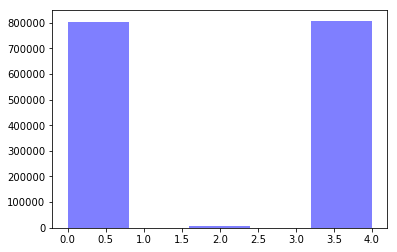

In [7]:
num_bins = 5
n, bins, patches = plt.hist(tweets.Sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Because the two corpora are combined, we see 3 categories in this Training Dataset. Negative = 0, Neutral = 2, Positive = 4

### Preprocessing & Feature Engineering

In [8]:
# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=100)

print(X_train[:5])
print(y_train[:5])

1418399    [Just, did, a, test, drive, with, the, BMW, 11...
1590568    [good, luck, lauren, ., i, know, you, are, goi...
1426864    [shipley's, donuts, sounds, amazing, right, no...
711160     [I, dont, like, it, at, all, ., its, confusing...
1576708                          [I, got, it, ..., hehehehe]
Name: SentimentTextTokenized, dtype: object
1418399    4
1590568    4
1426864    4
711160     0
1576708    4
Name: Sentiment, dtype: int64


### Convert Words into Vector Representation

Leveraging GenSim's Word2Vec model to convert our vocabulary into a vocabulary of word vectors.

In [9]:
# Specify the Word Vector Dimensionality
vector_dim = 128

# Threshold for words to be included (helps remove rare words)
thresh = 5

W2Vmodel = Word2Vec(size=vector_dim, min_count=thresh)
W2Vmodel.build_vocab(x for x in X_train)
W2Vmodel.train((x for x in X_train), total_examples=W2Vmodel.corpus_count, epochs=2)

14265774

Explore a few similar words using Word2Vec's most_similar function

In [10]:
def print_similar(word):
    print('##### %s #####' %word)
    for each in W2Vmodel.most_similar(str(word)):
        print('%i%% %s' %(each[1]*100, each[0]))
    print('')

print_similar('potato')
print_similar('hilarious')
print_similar('tuesday')
print_similar('trump')    

##### potato #####
92% banana
91% rice
91% homemade
91% mango
91% butter
90% strawberry
90% garlic
90% lemon
90% vanilla
90% fried

##### hilarious #####
82% funny
77% brilliant
77% AMAZING
77% adorable
76% scary
74% awesome
74% amazing
74% AWESOME
73% awsome
71% dope

##### tuesday #####
93% wednesday
91% thursday
83% monday
77% wed
76% friday
76% thurs
74% fri
73% Tuesday
73% tues
73% Wednesday

##### trump #####
87% Jets
87% Vettel
87% Oil
86% Extension
86% Mystic
86% carbon
86% ala
86% assistir
86% Cisco
86% Coco



### Convert Tweets into Vector Representation

First attempt was to simply average all of the word vectors present in a single tweet.

Second attempt utilized TFIDF rankings for each word to take into account the rarity/importance of that word within the overall corpus. 



In [11]:
def buildTweetVector(tokens, vector_dim):
    
    # Initialize a blank vector of shape (1,vector_dim)
    tweet_vec = np.zeros(vector_dim).reshape((1, vector_dim))
    
    # Initialize # of words in tweet count
    count = 0.
    
    for word in tokens:
        try:
            # Take each word vector in the tweet and add each dimension to the overall tweet vector
            tweet_vec += W2Vmodel[word].reshape((1, vector_dim))
            
            # Increment Count
            count += 1.
            
        except:
            continue
    
    # Average each vector parameter by the # of words in the tweet (pass if no words exist in tweet)
    if count != 0:
        tweet_vec /= count
    
    # Return Tweet Vector
    return tweet_vec

#### Build TFIDF Dictionary

In [12]:
# Fit a TFIDF vectorizer model to the training set
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
vectorizer.fit_transform([x for x in X_train])

# Extract IDF values from model and place into a dictionary
tfidf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [13]:
def buildTweetVectorTFIDF(tokens, vector_dim):
    
    # Initialize a blank vector of shape (1,vector_dim)
    tweet_vec = np.zeros(vector_dim).reshape((1, vector_dim))
    
    # Initialize # of words in tweet count
    count = 0.
    
    for word in tokens:
        try:
            # Same as above, only now multiply the tfidf score for the current word by its vector 
            # (to add additional weight to more important words with respect to the corpus)
            tweet_vec += W2Vmodel[word].reshape((1, vector_dim)) * tfidf_dict[word]
            
            # Increment Count
            count += 1.
            
        except:
            continue
    
    # Average each vector parameter by the # of words in the tweet (pass if no words exist in tweet)
    if count != 0:
        tweet_vec /= count
    
    # Return Tweet Vector
    return tweet_vec

#### Turn Training and Test Sets into Tweet Vectors
Pass each tweet in the Training/Test Sets into the buildTweetVector function and reassemble training/test set structure

In [14]:
X_train_tweet_vecs = np.concatenate([buildTweetVectorTFIDF(vec, vector_dim) for vec in map(lambda x: x, X_train)])
X_test_tweet_vecs = np.concatenate([buildTweetVectorTFIDF(vec, vector_dim) for vec in map(lambda x: x, X_test)])

#### Scale each Vector

In [15]:
scaler = StandardScaler()
scaler.fit(X_train_tweet_vecs)
X_train_tweet_vecs = scaler.transform(X_train_tweet_vecs)
X_test_tweet_vecs = scaler.transform(X_test_tweet_vecs)

#### Encode the Y Labels as Categorical Variable and then One-hot Encode (for multi-class classification)

In [16]:
print("Original Y:", y_train[:10])
encoder = LabelEncoder()
encoder.fit(Y)
y_train = encoder.transform(y_train)
y_test= encoder.transform(y_test)
print("Encoded Y:", y_train[:10])

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print("One Hot Y:", y_train[:10])

Original Y: 1418399    4
1590568    4
1426864    4
711160     0
1576708    4
54615      0
6138       2
974273     4
84989      0
1397183    4
Name: Sentiment, dtype: int64
Encoded Y: [2 2 2 0 2 0 1 2 0 2]
One Hot Y: [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]


## Fit a 'Simple' Neural Network Model using the Tweet Vectors as Features

Using Keras & Tensorflow backend.

In [17]:
# Keras Model w/ Two Affine Layers
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=vector_dim))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax')) # softmax for multi-class
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical_crossentropy if multi-class
              metrics=['accuracy'])

model.fit(X_train_tweet_vecs, y_train, epochs=3, batch_size=32, verbose=2)

Epoch 1/3
 - 36s - loss: 0.5262 - acc: 0.7555
Epoch 2/3
 - 35s - loss: 0.5179 - acc: 0.7632
Epoch 3/3
 - 37s - loss: 0.5178 - acc: 0.7645


#### Evaluate Model on Test Set

In [18]:
accuracy = model.evaluate(X_test_tweet_vecs, y_test, batch_size=32, verbose=2)
print("Accuracy: %.2f%%" % (accuracy[1]*100))

Accuracy: 77.11%


#### Save Keras Model

In [19]:
# Save Keras Model to File (not working on Matt's computer)
# model.save('sentiment_model.h5')

### Apply Fitted Model to Reddit

In [20]:
# Function to Predict Positive/Neutral/Negative
# def prediction(text):
#     sentiment = ["Negative",'Neutral', "Positive"]
#     text = text.split() # Tokenize
#     text = buildTweetVectorTFIDF(text, vector_dim)
#     text = scaler.transform(text)
#     prediction = model.predict(text, batch_size=32)
#     result = sentiment[prediction.argmax(axis=1)[0]]
#     return result

def prediction(text):
    sentiment = ["Negative",'Neutral', "Positive"]
    tokens = create_tokens(text)
    vectors = buildTweetVectorTFIDF(tokens, vector_dim)
    vectors = scaler.transform(vectors)
    predic = model.predict(vectors)
    result = sentiment[predic.argmax(axis=1)[0]]
    return result

# Load saved Keras Model from File (not working on Matt's computer)
# my_model = load_model('sentiment_model.h5')

#### Using the praw package to interact with Reddit's API and pull all comments from a single page

In [21]:
# Initialize a read-only instance
reddit = praw.Reddit(user_agent='first_scrape (by /u/dswald)',
                     client_id='TyAK1zSuAvQjmA', 
                     client_secret="uxHGsL0zNODbowN6umVnBWpqLAQ")

# Select Url / Subreddit page to view
page = 'portland'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'        
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(submission.title,
                                                                          submission.ups,
                                                                          submission.downs,
                                                                          submission.visited))
        
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads
        comments = submission.comments.list() #unstructured
        for comment in comments:
            print (20*'-')
            print ('Parent ID:', comment.parent())
            print ('Comment ID:', comment.id)
            print (comment.body)
            print("#"*10,'PREDICTED SENTIMENT:', prediction(comment.body),"#"*10)

Title: Portland from Mt. Hood, instead of the usual, ups: 1120, downs: 0, Have we visited: False
--------------------
Parent ID: 7j3g92
Comment ID: dr3fntj
!! so beautiful. I had a really hard day on saturday and as I turned the corner on the I5 I saw mt. hood all bright and clear in the sun and she made me cry! we’re so lucky to have that view
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j3g92
Comment ID: dr3hd1l
great place for a zip-line ride
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j3g92
Comment ID: dr3eiz3
I nominate this for the sidebar photo.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j3g92
Comment ID: dr3ryq1
I'll say this: Mt. Hood looks a lot more impressive from Portland than Portland looks from Mt. Hood. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j3g92
Comment ID: dr3dlag
Did you go up this weekend? The wind

--------------------
Parent ID: 7j43nk
Comment ID: dr3if0h
She was a great mayor and a really inspiring person. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j43nk
Comment ID: dr3h8qr
To put into perspective, Vera Katz served the same length as her successors Potter, Adams and Hales combined. Portland has been lacking in leadership.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j43nk
Comment ID: dr3i6lo
She was an amazing person!
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j43nk
Comment ID: dr3jex8
I had the pleasure of meeting her a time or two, she was an amazingly kind lady. 

Rest in Peace Mayor Katz, you will be missed
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7j43nk
Comment ID: dr3k457
She used to come to our yearly block party in North Portland.

RIP Vera :(
########## PREDICTED SENTIMENT: Negative ##########
----------

### Limitations of this corpora on the Reddit Feeds

Unfortunately, sentence structure on Reddit appears to be substantially different compared to tweet structure on Twitter both in grammar use and in length of post. Because the model was built using a corpus that is only 140 characters long (maximum). Considering the creation of a Tweet vector is just an averaging across all of the individual word vectors, theoretically this process should translate to a full Reddit sentence though due to the increased length of a Reddit sentence any 'rare' or 'important words' seen will be more likely to be averaged out in a longer post.

# Building a Graph/Network from the Positive / Negative Comments on a Single Reddit Post
Generate a Graph with Nodes = Comments and Edges = Link between Parent Comments and Child Comments.  
Calculate the 'weight' of a single node in the network of comments by evaluating it's degree within the network (degree of connectivity).  
A weighted average calculation is then performed to determine the overall % of positive posts within the page.  
Additionally, the network is plotted to visually see the breakdown of positive/negative comments following the original post.
Green Dots = Predicted Positive Comments, Red Dots = Predicted Negative Comments

In [22]:
def page_network_and_sentiment(page='news', layout='random'):
    
    # Access Subreddit Page and Content via praw
    subreddit = reddit.subreddit(page)
    hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
    col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']
    df = pd.DataFrame(columns = col_list)

    # Build a Dictionary to hold all submissions (posts) and their comment networks
    G_dict = {}

    for submission in hot_python:
        if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
            submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

            comments = submission.comments.list() #unstructured
            
            # Initialize a Graph for the Comments of a single post
            G = nx.DiGraph()
            positive_nodes = []
            negative_nodes = []
            
            # Empty dict
            degrees = {}
            for i in range(1,31):
                degrees[i] = []
            
            # Build the Graph
            for i, comment in enumerate(comments):
                df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
                try:
                    sentiment = str(prediction(comment.body))
                    if sentiment == "Negative":
                        negative_nodes.append(comment.id)
    #                     degree.append(nx.degree(G))
                    if sentiment == "Positive":
                        positive_nodes.append(comment.id)
                    G.add_node(comment.id)
                    G.add_edge(comment.parent(), comment.id)
                except:
                    continue

            # Calculate the degree of all nodes in the Graph
            degree = nx.degree(G)
            
            # Build a list of nodes for each degree up to 30 and bin together anything above 30 (for plotting)
            for id,count in degree.items():
                for i in range(1,30):
                    if count == i:
                        degrees[i].append(id)
                if count >= 30:
                    degrees[30].append(id)
            
            # Add to dict
            G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)

    # Export Predictions and Comment Text to CSV
    df.to_csv(page+'.csv', encoding='utf-8', index=False)

    # Loop through all items in the Dict and plot each individual Graph
    i = 0
    for sub,G in G_dict.items():
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                      sub.ups,
                                                                      sub.downs,
                                                                      sub.visited))
        i += 1
        
        # Select the style of Graph Layout
        if layout == 'random':
            pos = nx.random_layout(G[0])
        if layout == 'pydot':
            pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')
        if layout == 'spectral':
            pos = nx.spectral_layout(G[0])
        if layout == 'spring':
            pos = nx.spring_layout(G[0])
        if layout == 'circular':
            pos = nx.circular_layout(G[0])

        # Initialize Plot
        plt.figure(figsize=(16, 16))
        plt.subplot(len(G_dict), 1, i)
        
        # Initialize Score Parameters
        total_pos_score = 0
        total_neg_score = 0
        total_weighted_pos_score = 0
        total_weighted_neg_score = 0

        # Calculate individual comment scores & Node Size via degree values * positive/negative sentiment
        for j in range(1,31):
            pos_j = []
            neg_j = []
            for k in G[3][j]:
                if k in G[1]:
                    pos_j.append(k)
                    total_weighted_pos_score += j*1
                    total_pos_score += 1
                if k in G[2]:
                    neg_j.append(k)
                    total_weighted_neg_score += j*1
                    total_neg_score += 1

            # Draw Network    
            nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
            nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
            
        nx.draw_networkx_edges(G[0], pos, alpha=0.1)
        plt.axis('off')
        plt.show()

        # Print Scores to Screen
        overall_page_score = total_pos_score / (total_pos_score + total_neg_score)
        overall_weighted_page_score = total_weighted_pos_score / (total_weighted_pos_score + total_weighted_neg_score)
        print("Overall Page Positivity Score: %0.2f%%" %(overall_page_score*100))
        print("Overall Weighted Page Positivity Score: %0.2f%%" %(overall_weighted_page_score*100))
        print("")

## Results for Specific Pages

### News

Title: Net neutrality: 'father of internet' joins tech leaders in condemning repeal plan, ups: 35374, downs: 0, Have we visited: False


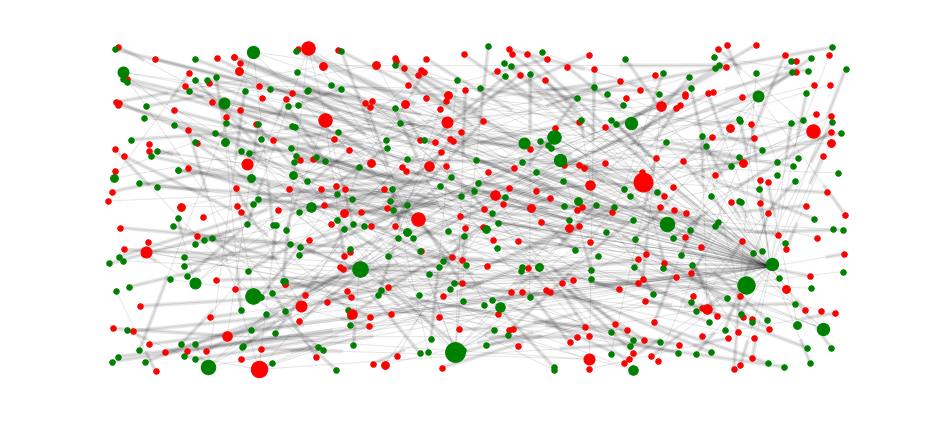

Overall Page Positivity Score: 49.92%
Overall Weighted Page Positivity Score: 51.14%

Title: Analyst cuts EA profit estimates after social media uproar leads to 'Star Wars' game sales plunge, ups: 4468, downs: 0, Have we visited: False


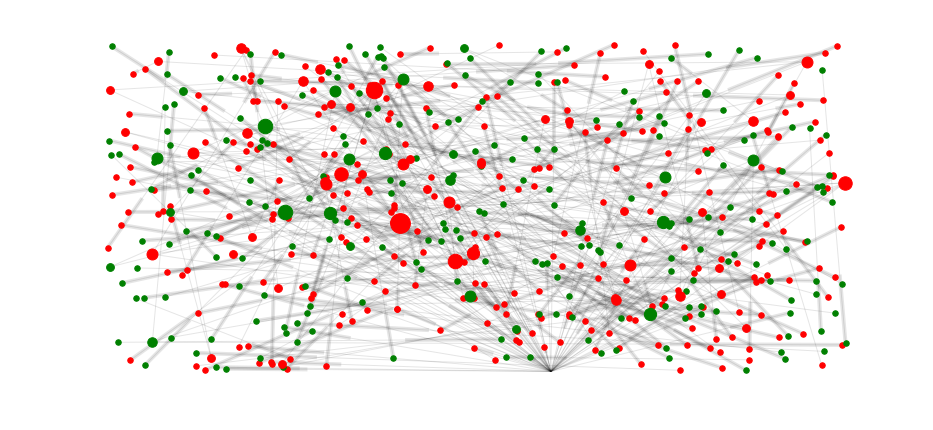

Overall Page Positivity Score: 41.90%
Overall Weighted Page Positivity Score: 40.91%



In [23]:
page_network_and_sentiment(page='news', layout='random')

In [24]:
page_network_and_sentiment(page='news', layout='pydot')

Title: Net neutrality: 'father of internet' joins tech leaders in condemning repeal plan, ups: 35387, downs: 0, Have we visited: False


InvocationException: GraphViz's executables not found

### Canada

In [ ]:
page_network_and_sentiment(page='canada', layout='random')

In [ ]:
page_network_and_sentiment(page='canada', layout='pydot')

### Movies

In [ ]:
page_network_and_sentiment(page='movies', layout='random')

In [ ]:
page_network_and_sentiment(page='movies', layout='pydot')

### Funny

In [ ]:
page_network_and_sentiment(page='funny', layout='random')

In [ ]:
page_network_and_sentiment(page='funny', layout='pydot')

### Los Angeles

In [ ]:
page_network_and_sentiment(page='losangeles', layout='random')

In [ ]:
page_network_and_sentiment(page='losangeles', layout='pydot')

### Star Wars

In [ ]:
page_network_and_sentiment(page='starwars', layout='random')

In [ ]:
page_network_and_sentiment(page='starwars', layout='pydot')